# Tutorial 5: RJMCMC with Eryn

In the fifth tutorial, we will look at running Eryn when the underlying model is changing. This means we will be using Reversible-Jump MCMC, also referred to as trans-dimensional MCMC. In this tutorial, there will only be 2 tasks because RJMCMC is complicated and putting together an RJMCMC run takes time and effort. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools import *
from copy import deepcopy  # can be useful

## Task 1: How many Gaussian pulses?

The first RJ problem we will look at is determining how many 2D Gaussian pulses exist in a noisy set of data. This is an example you can find in the more advanced Eryn tutorials. To keep this simple in the time we have alotted, we will use a proposal based on the prior distribution (this is the default). If you set `rj_moves=True` in the setup of `EnsembleSampler`, it will automatically generate RJ proposals from the prior. However, you must be careful when using multiple branches (model types) because this proposal, by default, always proposes to change each model in the sampler by 1 model count, either add or remove. 

Useful documentation:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)
* [DistributionGenerateRJ](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.DistributionGenerateRJ)

In [4]:
!pip install chainconsumer

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.9/407.9 kB 8.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 9.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.7 MB/s eta 0:00:00


In [5]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend
from chainconsumer import ChainConsumer, Chain

We will do the initial setup for you. Here we are going to set the x and y dimensions of our 2D grid.

In [6]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim) / num # Get the discritization

x, y = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx]  # Generate the grid

Now, we will draw initial parameters for each set of pules. Each pulse gets an amplitude, x, and y value.

In [7]:
Amp    = np.random.uniform(.5, 2.0, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity.
sigma  = spread * np.diag(np.ones(2))

edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set

# Draw the coordinates parameters
# generates random x and y coordinates
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = np.concatenate([Amp[:, None], inj_coordinates], axis=1)

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 0.80897454  3.28501642  6.00941287]
 [ 0.56087111 -3.64522082  1.84244618]
 [ 1.96524745  7.54028181  4.09301549]
 [ 1.40755214  7.17213785  1.57240571]
 [ 1.90137041  5.41994241  7.9352386 ]
 [ 1.62586875  3.92410927  5.59288261]
 [ 0.68616228 -6.32617788  3.90771483]
 [ 0.83055165  3.12424819  5.94335919]
 [ 1.52393229  1.41596507 -2.30601152]
 [ 1.49003089 -1.6529102   7.53637887]]


We have also filled in the Gaussian function and Likelihood to avoid any issues. The next few cells give an idea of the injection data. 

In [8]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[None, :] - c[:, None]) ** 2) / (2 * sigma[1,1]))
    # breakpoint()
    C =  A[:, None, :] * B[:, :, None] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))

    return a[:, None, None] * C / norm

def log_prob_fn(x1, X, Y, data, sig):

    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    template  = np.sum(gaussian(X, Y, a, b, c), axis=0)

    llh = - 0.5 * ( np.sum(((template - data)) ** 2) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

In [9]:
noise = spread * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
injection = np.sum(gaussian(x, y, gauss_inj_params[:, 0], gauss_inj_params[:, 1], gauss_inj_params[:, 2]), axis=0)
data = injection + noise


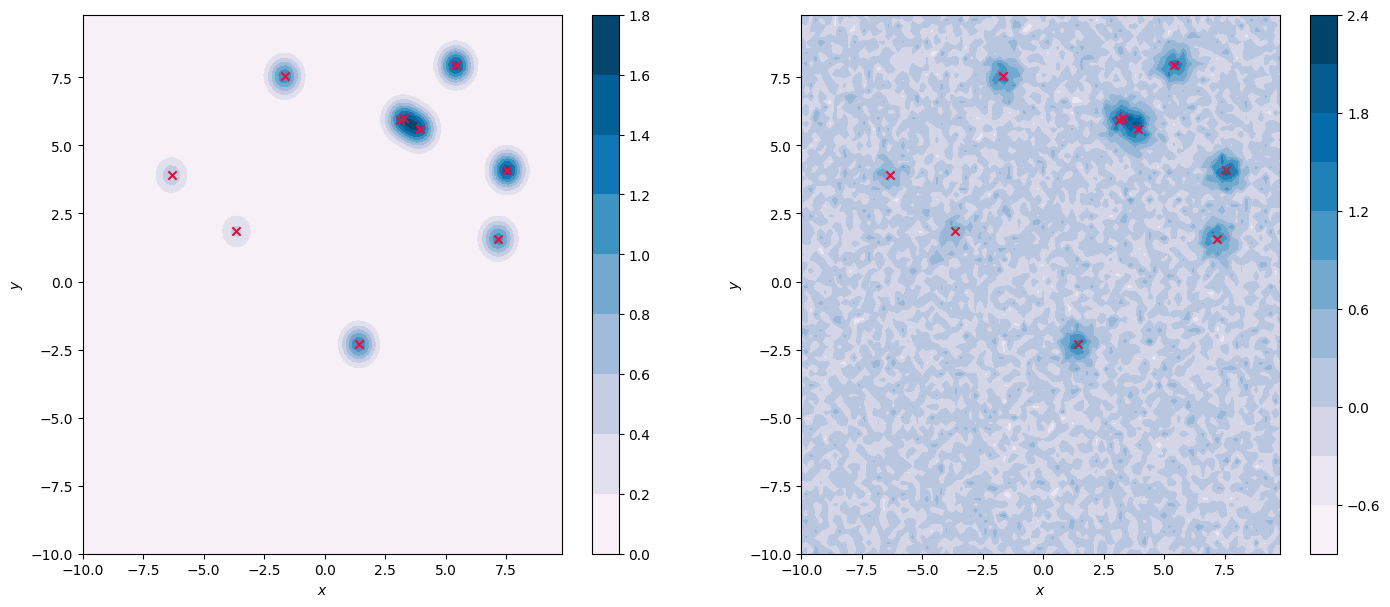

In [10]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(y, x, injection, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(y, x, data, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()


Now that we have most of the initial setup. We now need to build our sampling run. Let's start by choosing settings and building base requirements: `ndims`, `nleaves_max`, `nleaves_min`, `branch_names`, `ntemps`, `nwalkers`.

In [11]:
ntemps = 10
nwalkers = 30

ndims        = {"pulse": 3}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"pulse": 2*npulses}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"pulse": 0}
branch_names = ["pulse"]


Now we will setup our prior function. Make sure you initialize your prior with the `ProbDistContainer` object from Eryn. 
* For the amplitude, a uniform prior from 0.5 to 2.0.
* For x and y, uniform priors across the acceptable ranges.

In [12]:
priors = {
    "pulse": ProbDistContainer({
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    })
}

When using RJMCMC, we must input a value for `moves` in the `EnsembleSampler`. This is because the default proposal (Stretch proposal) does not work in varying dimensionality. We will keep this simple and use a Gaussian proposal centered on the current point. We recommend a diagonal covariance matrix with the same covariance for each parameter. There are many ways to do this. 

Useful Documentation:
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)

In [13]:
# imports 
from eryn.moves import GaussianMove

In [14]:
factor = 0.01
cov    = {"pulse": np.diag(np.ones(3)) * factor}
moves = GaussianMove(cov)

Now we will instantiate the `EnsembleSampler`. For the tempering, set `tempering_kwargs=dict(ntemps=ntemps)`. 

In [15]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data, sigma_det],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,
)

 # Number of samples per walker




With the sampler prepared, we just need to generate our starting points. There are also many choices for this. In RJMCMC, it is more complicated because of the model uncertainty. For this simplified example, we are going to start by drawing **1 Gaussian per walker** from the prior. It will add more as the goes. Your goal here is to produce a `coords` dictionary of shape `(ntemps, nwalkers, nleaves_max, ndim)`. You can sample every source in that `coords` array because we will direct to have **only one** leaf per walker with the `inds` dictionary. `inds` should be a boolean array of shape `(ntemps, nwalkers, nleaves_max)`. You then index this and set one value to True per walker. Fill these dictionaries into a `State` object.

In [16]:
# nleaves max here is just for correct shape. Will turn off all but 1 per walker to start
coords = {
    name: priors[name].rvs(size=(ntemps, nwalkers, nleaves_max[name]))
    for name in branch_names
} 

inds_tmp = np.zeros(coords['pulse'].shape[:-1], dtype=bool)
inds_tmp[:, :, 0] = True

inds = {'pulse': inds_tmp}
state = State(coords, inds=inds)

Now run the sampler. We recommend a good burn in.

In [17]:
nsteps = 5000
output = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

100%|██████████| 5000/5000 [18:33<00:00,  4.49it/s]


Now read out the number of leaves per walker in the cold chain using the `ensemble.backend`. You only need the `inds` array for this. Plot a histogram of number of pulses found in the cold chain. This is a posterior distribution on the model count. 

Useful Documentation:
* [Backend](https://mikekatz04.github.io/Eryn/html/user/backend.html#eryn.backends.Backend)

Text(0.5, 0, '$\\#$ of peaks in the data')

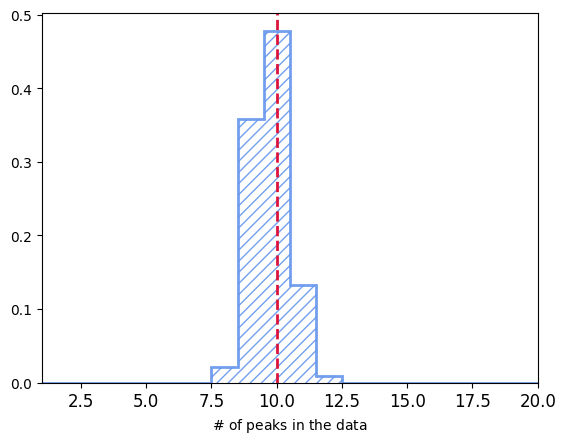

In [18]:
# get leaves from all steps after burn-in and remove higher temperature chains 
# this is the 0 index below
nleaves = ensemble.backend.get_nleaves()["pulse"][:, 0].flatten() 

bins = (np.arange(1, nleaves_max['pulse'] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

plt.hist(
    nleaves,
    bins=bins,
    color='#6495ed',
    alpha=0.9,
    lw=2,
    histtype='step',
    density=True,
    hatch='///'
)

# injection line 

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')
plt.xticks(fontsize=12)
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")

### Question:
Is this what you expected? Does RJMCMC tell us what the "right" answer is? How do you think the noise effects this posterior plot? If we increase the noise, what type of changes do we expect and why?

Now we will look at the parameters of the recovered pulses to see how well we located the injected pulses. To do this, we are going to flatten all of samples from all leaf counts found, i.e. we will take every single source in the cold chain and plot all of these overlayed. **Hint**: use the `inds` array to your advantage here.

We recommend using `pandas` and `chainconsumer` to do this, but you can do it anyway you like. 

In [19]:
import pandas as pd

Parameter $A$ in chain Test is not constrained
Parameter $x$ in chain Test is not constrained


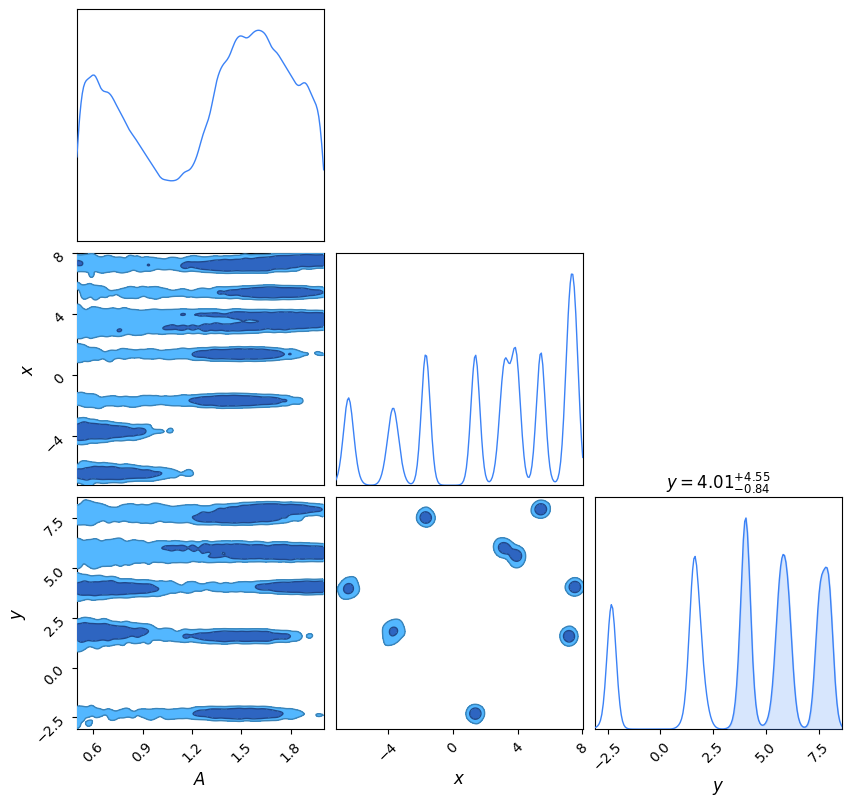

In [20]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]

samples_pulses = ensemble.backend.get_chain()['pulse'][ensemble.backend.get_inds()["pulse"]]

df = pd.DataFrame({key: val for key, val in zip(pulse_parameters, samples_pulses.T)})
c = ChainConsumer()
check = int(3)
c.add_chain(Chain(samples=df, name="Test", smooth=check))
fig = c.plotter.plot()

### Question:
How did we do? Was it a success? Could there be improvements? 

## Task 2: Model selection with RJMCMC

In this task, you will use RJMCMC to do a direct model comparison. This will be the same model comparison used in Tutorial 3 comparing a Gaussian pulse with a Cauchy pulse. In tutorial 3, we used fixed-dimensional MCMC and thermodynamic integration to estimate the evidence of each model. Then we compared them to get the Bayes Factor. Using RJMCMC will produce a posterior distribution on the model selection index rather than a direct evidence for each model. The fraction of walkers that have highlighted one model over the other represents a proxy for the odds ratio. This is not strictly true when one model is much more favored than another. However, when model favorability is close, this direct computation is okay. 

For simplicity, we will consider the spread of the signal to be 1. Therefore, we are only fitting and comparing the amplitude and mean of the pulse. 

Once again, we will start by providing the functions for the Gaussian pulse, Cauchy pulse, and the Likelihood function. 

In [21]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

def log_like_wrap(params, *args):
    # must be careful about how these models are read into the Likelihood function
    # In this case, we will have one model with a single set of parameters 
    # and one model that is None
    
    assert len(params) == 2
    if params[0] is not None:
        assert params[1] is None
        # gauss will be first set of params
        args += ("gauss",)
        ll = log_like_fn(params[0][0], *args)

    else:
        assert params[0] is None
        # gauss will be first set of params
        args += ("cauchy",)
        ll = log_like_fn(params[1][0], *args)

    return ll

We will inject the Gausian pulse and compare to the Cauchy pulse.

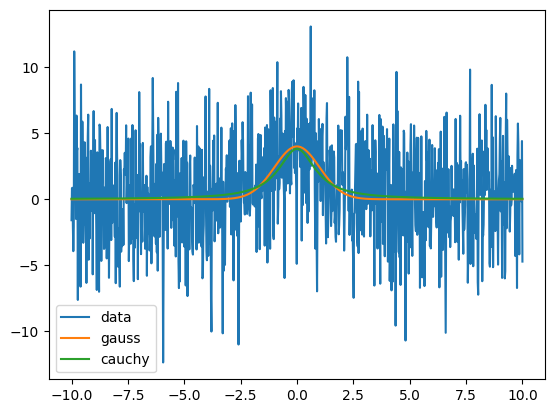

In [22]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 3.5
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

We will follow the same setup order as the last problem. Start with the basic declarations (`ntemps`, `ndims`, etc.). For this problem, the max leaves for both models should be 1 and the min leaves for both models should be 0. 

In [23]:
ntemps = 10
nwalkers = 30

ndims        = {"gauss": 2, "cauchy": 2}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"gauss": 1, "cauchy": 1}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"gauss": 0, "cauchy": 0}
branch_names = ["gauss", "cauchy"]



Now we will put together the priors for both models. The priors are identical really for the two models. The amplitude prior should span the injection values. The mean prior should span the domain of time.

In [24]:
priors = {}
priors["gauss"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

priors["cauchy"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

Now we will produce the same type of `GaussianMove` that we built earlier. We need to make sure that to provide a covariance for each model! So, it must be a dictionary with entries for both models. The entries can really be the same though. 

In [25]:
factor = 0.01
cov    = {"gauss": np.diag(np.ones(2)) * factor, "cauchy": np.diag(np.ones(2)) * factor}
moves = GaussianMove(cov)

Instantiate the `EnsembleSampler`.

In [26]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    log_like_wrap,
    priors,
    nbranches=2,
    branch_names=branch_names,  # order determines order of parameter sets in Likelihood
    tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf),
    args=(t_vals, data, sigma),
    rj_moves=True,
    moves=moves,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min
)

Generate start points. **Note**: this is very important. This test will only work if:
* we have **2** models,
* each model has max leaves of 1 and min leaves of 0,
* and the starting points must all have **either** the Gaussian or Cauchy pulse, not both and not neither.

In this setup, each proposal will propose to switch the model and draw from its prior. 

Generate your start point and use the `inds` array to tell the sampler that each walker has only one model instance. 

In [27]:
start_point = {name: priors[name].rvs(size=(ntemps, nwalkers, 1)) for name in branch_names}

# draw randomly which model to start in 
model_index = np.random.randint(0, 2, size=(ntemps, nwalkers, 1))

inds = {name: np.zeros((ntemps, nwalkers, 1), dtype=bool) for name in branch_names}

inds["gauss"][model_index == 0] = True
inds["cauchy"][model_index == 1] = True

assert np.all(inds["gauss"].astype(int) + inds["cauchy"].astype(int) == 1)
start_state = State(start_point, inds=inds)



Run the sampler with a burn-in.

In [28]:
nteps = 500
sampler.run_mcmc(start_state, nsteps, progress=True, burn=100)

100%|██████████| 5000/5000 [04:20<00:00, 19.17it/s]


To find our posterior odds ratio, we need to get the fraction of cold-chain samples that exist in one of the two states. Calculate the odds ratio.

In [29]:
nleaves = sampler.get_nleaves()

In [30]:
# number of cold-chain Gaussians / number of cold-chain samples
nleaves["gauss"][:, 0].sum() / np.prod(nleaves["gauss"][:, 0].shape)

0.04576

### Question:
If we change the noise, what effect will this have on our results? What happens when one model is heavily favored so that the fraction is 1? Is this a proper estimate of the odds ratio? What could we do in this case where the initial odds ratio is 1 to actually estimate the odds ratio?

影响结果的噪声变化：改变噪声水平会影响模型对数据的拟合程度。较高的噪声可能会导致模型的似然值下降，使得模型之间的证据差异变得更加明显。
模型偏好时的影响：当一个模型受到极大偏好，使得其分数为1时，该模型的证据远远超过其他模型。在这种情况下，贝叶斯因子会趋向于无穷大，该模型被视为极具支持度。但这并不意味着这是对赔率比的正确估计。
赔率比的正确估计：如果初始赔率比为1，可以通过引入先验信息来实际估计赔率比。通过选择更合适的先验分布或增加数据量来改变赔率比的初始值。




In [ ]:
ntemps = 1  # 并行温度计算中的温度数量
ndims = 2   # 模型中的维度数量（例如，振幅和均值）
def create_prior(min_val, max_val):
    return lambda x: (min_val <= x <= max_val)

# 示例先验
amplitude_prior = create_prior(min_amplitude, max_amplitude)
mean_prior = create_prior(min_time, max_time)
from emcee.moves import GaussianMove

# 假设简化使用相同的协方差
covariance_matrix = np.array([[1, 0], [0, 1]])  # 根据需要调整
gaussian_move = GaussianMove(cov=covariance_matrix, mode='vector')
